In [1]:
from matplotlib import pyplot as plt
import numpy as np
from argparse import Namespace
import json

In [2]:
from scripts.train import DataModule, _to_image

In [3]:
with open('../config/cups.json', 'rt') as f:
    keypoint_config = json.load(f)
module = DataModule(Namespace(train='/home/ken/data/cups_train/', val='/home/ken/data/cups_test/', batch_size=1, workers=1, pool=32), keypoint_config=keypoint_config)
module.setup('fit')

train_loader = module.train_dataloader()
train_iterator = iter(train_loader)

In [4]:
import cv2
def resize(target, width=640, height=360):
    return cv2.resize(target, (width, height))
    

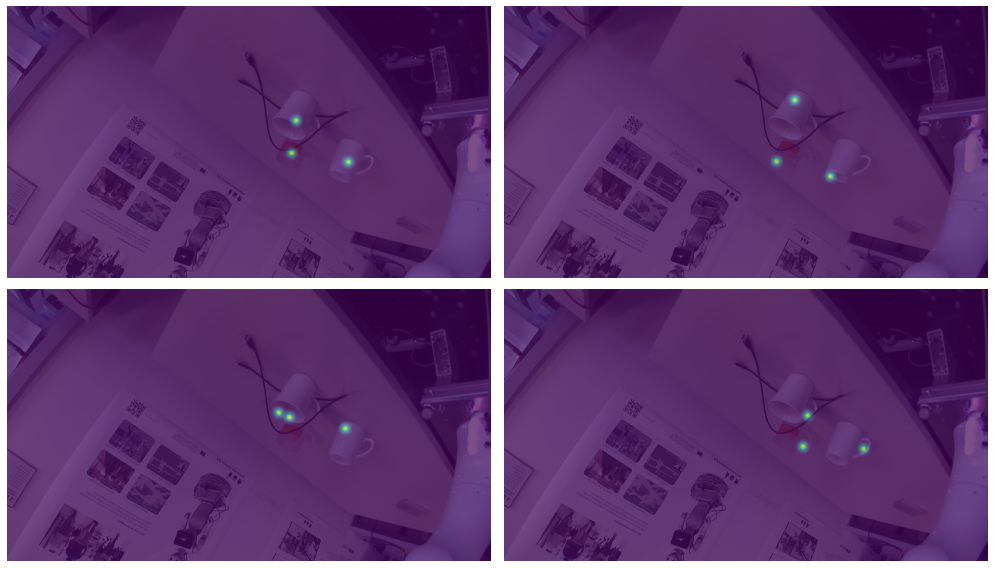

In [5]:
frame, target, depth, centers = next(train_iterator)

plt.figure(figsize=(14, 8))
image = _to_image(frame[0].numpy())
for i in range(2):
    for j in range(2):
        axis = plt.subplot2grid((2, 2), loc=(i, j))
        axis.imshow(image)
        axis.imshow(resize(target[0, i * 2 + j].numpy()), alpha=0.7)
        plt.axis('off')
plt.tight_layout()
pass

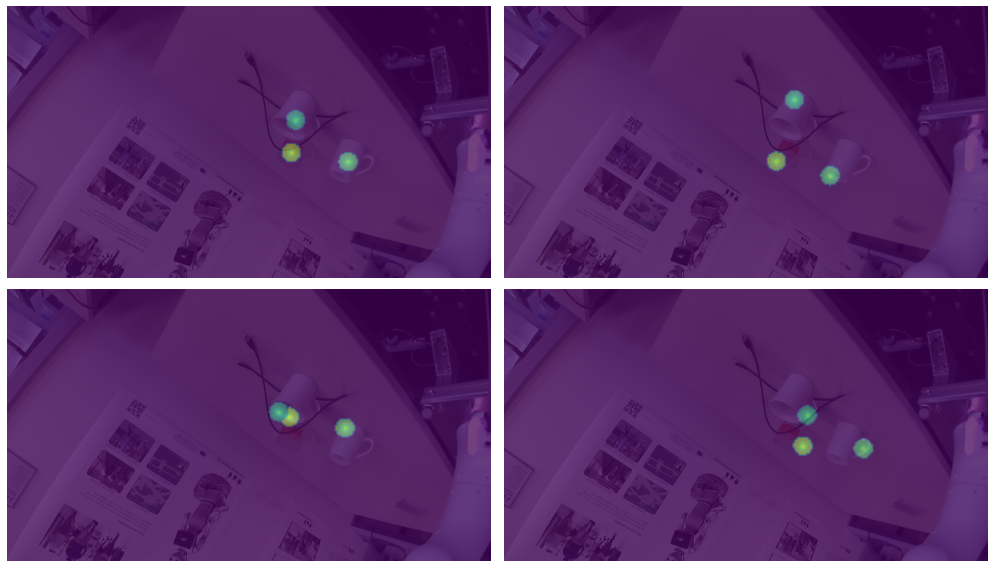

In [16]:
plt.figure(figsize=(14, 8))
for i in range(2):
    for j in range(2):
        axis = plt.subplot2grid((2, 2), loc=(i, j))
        axis.imshow(image)
        axis.imshow(resize(target[0, i * 2 + j].numpy()), alpha=0.5)
        axis.imshow(resize(depth[0, i * 2 + j].numpy()), alpha=0.5, vmin=0.0, vmax=1.0)
        plt.axis('off')
plt.tight_layout()
pass

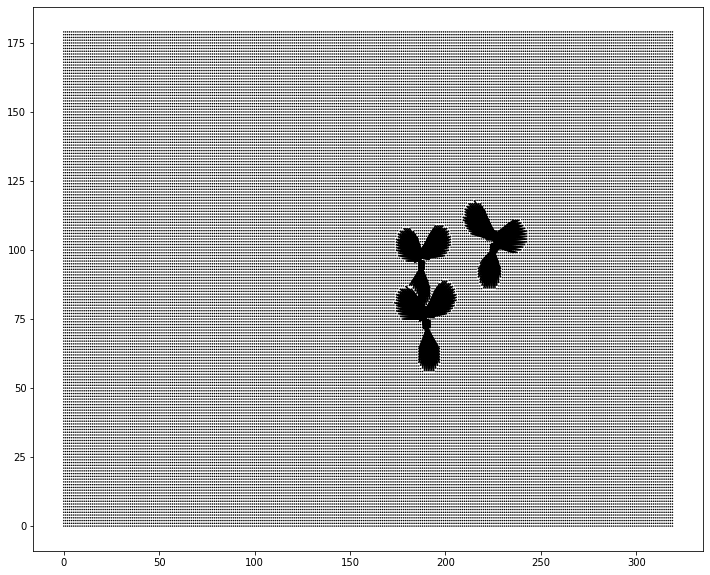

In [7]:
vectors = centers.numpy()[0]
indices = np.zeros((2, 180, 320), dtype=np.uint16)
for i in range(180):
    for j in range(320):
        indices[:, i, j] = [j, i]
plt.figure(figsize=(12, 10))
plt.quiver(vectors[0], vectors[1], units='xy', scale_units='xy', scale=1.0)
plt.show()


In [8]:
pixel_indices = np.zeros((2, 180, 320), dtype=np.float32)
for i in range(180):
    for j in range(320):
        pixel_indices[:, i, j] = [j + 0.5, i + 0.5]

In [9]:
norms = np.linalg.norm(vectors, axis=0)
where_non_zero = np.abs(norms) > 1e-1
centers = np.zeros((2, pixel_indices.shape[1], pixel_indices.shape[2]), dtype=np.float32)
centers[:, where_non_zero] = pixel_indices[:, where_non_zero] + vectors[:, where_non_zero]

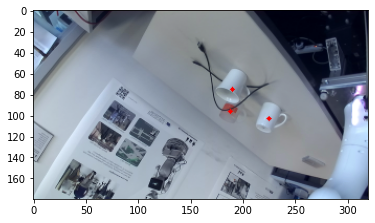

In [10]:
dotted_image = cv2.resize(image.copy(), (320, 180))
for point in centers[:, where_non_zero].transpose():    
    cv2.circle(dotted_image, (point[0], point[1]), 2, (255, 0, 0), -1)
plt.imshow(dotted_image)

In [11]:
assert centers[:, where_non_zero].shape[1] > 3
center_points = np.unique(centers[:, where_non_zero].round().astype(np.int32), axis=1)
assert center_points.shape[1] >= 1 and center_points.shape[1] < 5